In [1]:
import pandas as pd
import os
import re
import numpy as np
import fasttext
from tqdm import tqdm

### About the input file

- input file `predict_categories_dataset_ocrs.jsonl.gz` weights 316.1 MB  
about the file : https://openfoodfacts.org/data/dataforgood2022/big/predict_categories_dataset_documentation.txt  download the file : https://openfoodfacts.org/data/dataforgood2022/big/predict_categories_dataset_ocrs.jsonl.gz

- each line of the jsonl file contains OCRs associated with a barcode.
- each OCR contains text, potentially in different languages

### What is done in this notebook
- A DataFrame is made from the jsonl.gz
- All the OCRs of a product are concatenated
- For each product the different languages are detected.  
only the main language is kept (i.e the lang in which there are many words and a good confidence score)
- As there are many languages to work with, It is suggested to work with a Multilanguage sentence transformer.
- As the sentences can't properly be identified on a product we behave like there is only one big sentence 
- As the text may be very long for a product we need a way to extract only relevant words.
- The approach here is to filter by language and to create a TFIDF matrix.
- For each product of a given language we keep only the N-top words according to their TFIDF score.



In [2]:
path_ocrs = os.path.abspath("../datasets/predict_categories_dataset_ocrs.jsonl.gz")
#path_products = os.path.abspath("../datasets/predict_categories_dataset_products.jsonl.gz")


In [3]:
def get_row_from_json_for_df(json_line):
    """ extract items from json and returns a row to put in a dataframe """
    code = json_line['code']
    if "ocrs" in json_line:
        texts = []
        keys =  list(json_line['ocrs'].keys())
        for key in keys:
            ocr_text = json_line['ocrs'][key]['text']
            texts.append(ocr_text)
    row = [code, " ".join(texts), keys]
    return row

In [4]:
def artificial_sentence_split(text, n_words_per_sentence = 15):
    """splits artificially based on a pre-defined number of words. On average there are 15 words per sentence"""
    txt_split = text.split()
    total_words = len(txt_split)
    if total_words >= n_words_per_sentence:
        n_sentences = total_words // n_words_per_sentence
        rest = total_words % n_words_per_sentence
        chunks = [[i*n_words_per_sentence, (i+1)*n_words_per_sentence ] for i in range(n_sentences)]
        chunks[-1][1]+=rest
    else:
        chunks = [[0, total_words]]
    sentence_split = [" ".join(txt_split[slice(*chunk)]) for chunk in chunks]
    return sentence_split

def get_clean_lists_from_fasttext(lang_labels, probs_list):
    main_lang_idx = [np.argmax(items) for items in probs_list]
    lang_labels_output = [lang_label[i].split('__label__')[1] for lang_label, i in zip(lang_labels, main_lang_idx)]
    prob_list_output = [prob_list[i] for prob_list,i in zip(probs_list, main_lang_idx)]
    return lang_labels_output, prob_list_output

def text_lang_split(text:str):
    """
    takes text as input and splits it in a dictionnary with languages as keys.
    for each language we have subkeys such as:
    text: text found with the given language
    len_text: the length of the text
    prob: a list of probabilities, each probability corresponds to a sentence.  
    """
    text = re.sub(r"\n", " ", text)
    text = re.sub("\.+", ".", text)
    lang_dict = {}
    sentences = artificial_sentence_split(text)
    langs, probs = get_langs(sentences)
    for sentence, lang, prob in zip(sentences, langs, probs):
       
        if lang in lang_dict:
            lang_dict[lang]["prob"].append(prob)
            lang_dict[lang]["len_text"] += len(sentence)
            lang_dict[lang]["text"]+= sentence
            
        else:
            lang_dict[lang] = {}
            lang_dict[lang]["prob"] = [prob]
            lang_dict[lang]["len_text"] = len(sentence)
            lang_dict[lang]["text"] = sentence
            
    sorted_dict = {k: v for k, v in sorted(lang_dict.items(), key=lambda item: item[1]["len_text"], reverse = True)}
    main_lang = next(iter(sorted_dict))
    return main_lang, sorted_dict

def get_langs(sentences):
    lang_labels, probs_list = model.predict(sentences)
    langs, probs = get_clean_lists_from_fasttext(lang_labels, probs_list)
    return langs, probs


### Make DataFrame from jsonl

In [5]:
"""approx time 15sec"""
from IPython.display import clear_output
import gzip
import json
# make df from json
rows = []
with gzip.open(path_ocrs) as f:
    for i, line in enumerate(f):
        if i > 10000: # first 10 000 lines are potentially problematic we keep only further lines
            json_line = json.loads(line)
            row = get_row_from_json_for_df(json_line)
            rows.append(row)

df = pd.DataFrame(rows, columns = ["code", "texts", "keys"])
print(df.shape)

(793257, 3)


In [6]:
### Keep only real codes i.e codes with length = 13 characters.
real_codes =  df["code"].str.len() == 13
df = df[real_codes]
print("after removing non normalized codes", df.shape)
### Keep only texts > 10 char
len_sup_10 = (df["texts"].str.len()> 10)
df = df[len_sup_10]
print("after removing short texts", df.shape)


after removing non normalized codes (732516, 3)
after removing short texts (643357, 3)


### Extract main language text

for each text associated with a barcode, there are potentially many languages used to describe the product.
The aim of this section is to find the main language and to extract its text.

In [7]:
#load model
PRETRAINED_MODEL_PATH = '../datasets/lid.176.bin'
model = fasttext.load_model(PRETRAINED_MODEL_PATH)
clear_output()

def get_lang_items_from_pd_textlist(pdSeries) -> list:
    text_list= []
    lang_dict_list = []
    main_lang_list = []
    for t in tqdm(pdSeries):
        sentences = artificial_sentence_split(t)
        #detect and split text in a dict according to the languages found.
        main_lang, lang_dict = text_lang_split(t)
        text_to_keep = lang_dict[main_lang]["text"]
        text_list.append(text_to_keep)
        main_lang_list.append(main_lang)
        lang_dict_list.append(lang_dict)
    return text_list, lang_dict_list, main_lang_list

In [8]:
"""approx time 2min"""
text_list, lang_dict_list, main_lang_list = get_lang_items_from_pd_textlist(df['texts'])
main_lang_dict = {code: dic for (code,dic) in zip(df["code"], lang_dict_list)}
#assign new items to df
df["text_main_lang"] = text_list
df["main_lang"] = main_lang_list
df.head(2)

100%|██████████| 643357/643357 [01:33<00:00, 6845.59it/s]


,code,texts,keys,text_main_lang,main_lang
1,0041498293222,"""Percent Daily Values are based on a 2000\nNut...",[1],"""Percent Daily Values are based on a 2000 Nutr...",en
13,0041498310424,"INGREDIENTS: WHOLE ROLLED OATS,\nMILLED CANE S...","[2, 1, 3]","INGREDIENTS: WHOLE ROLLED OATS, MILLED CANE SU...",en


### cleaning

In [9]:
def text_cleaner(text):
  dont_take = ["kj", "kcal", "kj", "total", "free", "net", "ingredients", "ingredient", "et", "de", "fat", "mg", "cg", "g", "kg", "ml", "cl", "l", "kl", "per", "pour", "valeur", "or", "le", "la", "dont", "consommer", "poids", "net", "www", "com", "which", "of", "wt"]
  text_cleaned = text.replace("\n", " ") #remove line breaks
  text_cleaned = re.sub("\S*(www\.|\.com|\.net|\.fr|\.co\.uk|\.org)\S*", "", text_cleaned) #remove websites
  #text_cleaned = re.sub("[^A-Za-z0-9 \-àâäéèêëîïôöùûüÿçÂÊÎÔÛÄËÏÖÜÀÆæÇÉÈŒœÙ]", " ", text_cleaned) #keep alphanum and accents
  text_cleaned = re.sub("\w*([0-9]{0,}[,|\.]{0,}[0-9])\w*", " ", text_cleaned) #remove measurements 
  text_cleaned = re.sub(r"\b([a-zA-Z]{1})\b", " ", text_cleaned) # remove isolated letters ex --> g g g g g
  text_cleaned = re.sub("( +- +)", " ", text_cleaned)
  text_cleaned = re.sub(r"[\·|/|\-|\\|(|)|\+|\*|\[|\]|™|ᴿˣ|\*|\—|\^|\"|®|>|<|″|\||\&|\#|\,|\;|⭐|\xa0|\?|\%|\'|©|\@|\$|\€|\:|\}|\{|\°]", " ", text_cleaned)
  text_cleaned = re.sub(r" +", " ", text_cleaned) # remove multiple spaces

  text_cleaned = " ".join([w for w in text_cleaned.split() if (w.isalpha() and w.lower() not in dont_take)])
  return text_cleaned

In [10]:
import multiprocess as mp
def parallel_calc(iterable, func, n_core = mp.cpu_count()):
    pool = mp.Pool(n_core-1)
    results = pool.map(func, np.array(iterable))
    pool.close()
    return results

In [11]:
"""approx time 2m"""
#df["text_cleaned"] = df["text_main_lang"].apply(lambda x: text_cleaner(x))
#df = df.set_index("code", drop = True)

"""approx time 30sec"""
# simple wrapper code around text_cleaner to parallelize the work
df["text_cleaned"] = parallel_calc(df["text_main_lang"], text_cleaner)

In [12]:
df.head(3)

,code,texts,keys,text_main_lang,main_lang,text_cleaned
1,0041498293222,"""Percent Daily Values are based on a 2000\nNut...",[1],"""Percent Daily Values are based on a 2000 Nutr...",en,Percent Daily Values are based on Nutrition Fa...
13,0041498310424,"INGREDIENTS: WHOLE ROLLED OATS,\nMILLED CANE S...","[2, 1, 3]","INGREDIENTS: WHOLE ROLLED OATS, MILLED CANE SU...",en,WHOLE ROLLED OATS MILLED CANE SUGAR DRIED CRAN...
15,0041500007007,1901\nSince\n100% NATURA\nClassic\nMUSTARD\n80...,"[1, 3]",1901 Since 100% NATURA Classic MUSTARD 807 (22...,fr,Since NATURA Classic MUSTARD Réf Moutarde Fren...


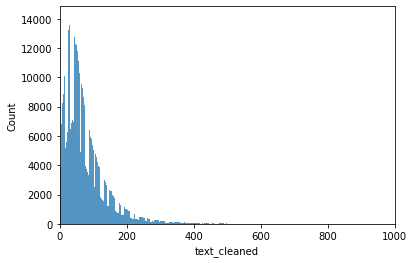

In [215]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
word_count = df['text_cleaned'].str.split().str.len()
sns.histplot(word_count)
plt.xlim([0,1000])
plt.show()


### TFIDF Trick

In [13]:
def get_words_with_highest_scores(scores, words, n_words_to_take):
  """
  takes scores and words of an OCR as inputs and returns 
  words with highest tfidf scores
  """
  items = [item for item in sorted(zip(scores, words), reverse = True)]
  best_items = items[:n_words_to_take]
  return best_items, items

def get_words_and_scores_from_tfidf_matrix(doc, cols, tfidf_matrix, index_to_word):
  """
  takes a document (line of tfidf matrix) and its words (columns of tfidf matrix
  and returns words of the documents with their ifidf scores
  columns are the non zero values of the tfidf matrix.
  """
  scores = []
  words = []
  for col in cols:
    word = index_to_word[col] 
    score = tfidf_matrix[doc, col]
    words.append(word)
    scores.append(score)
  return words, scores

def text_selection(df_idx, sub_df_idx,  index_to_word, tfidf_matrix, n_words_to_take = 30):
  rows, cols = tfidf_matrix[sub_df_idx].nonzero()
  ## extract words and scores from tfidf matrix
  words, scores = get_words_and_scores_from_tfidf_matrix(sub_df_idx, cols, tfidf_matrix, index_to_word)
  #extract words with highest score from sentence
  best_items, items = get_words_with_highest_scores(scores, words, n_words_to_take)
  best_words = [item[1] for item in best_items]
  
  text_selection = " ".join([word for word in df["text_cleaned"].iloc[df_idx].split() if str(word).lower() in best_words])
  text_selection = " ".join(best_words)
  text_selection_unique = remove_duplicates(text_selection)
  return text_selection_unique, items

def text_selection_from_Series(text_Series, tfidf_matrix, index_to_word):
  text_selection_list = []
  items_list = []
  for sub_df_idx, df_idx in enumerate(tqdm(text_Series.index)):
    text_selection_unique, items = text_selection(df_idx, sub_df_idx, index_to_word, tfidf_matrix, n_words_to_take = 30)
    text_selection_list.append(text_selection_unique)
    items_list.append(items)
  return text_selection_list, items_list

def get_index_to_word_dict(vectorizer):
  index_to_word = {index: word for index, word in zip(vectorizer.vocabulary_.values(), vectorizer.vocabulary_.keys())}
  return index_to_word

In [14]:
def remove_duplicates(text, get_keys = False):
    D = {word.lower(): word  for word in str(text).split()}
    if get_keys:
        return " ".join(D.keys())
    else:
        return " ".join(D.values())

### All lang

In [15]:
df["tfidf_selection"] = ""
clear_output()

In [16]:
"""takes approx 8min"""
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import clear_output
problematic_langs = []
df = df.reset_index(drop = True)
for lang in df["main_lang"].unique():
    print("lang:", lang)
    lang_filter = df["main_lang"]== lang 
    df_l = df[lang_filter]
    try:
        vectorizer = TfidfVectorizer(min_df = 2, max_df = 0.8)
        tfidf_matrix = vectorizer.fit_transform(df_l["text_cleaned"])
        index_to_word = get_index_to_word_dict(vectorizer)
        text_selection_list, items_list =  text_selection_from_Series(df_l["text_cleaned"], tfidf_matrix, index_to_word)
        df.loc[lang_filter, "tfidf_selection"] = text_selection_list
    except:
        problematic_langs.append(lang)
    clear_output()

In [17]:
len(problematic_langs)

37

In [18]:
df.loc[df["tfidf_selection"] == "",:].shape

(1790, 7)

### Intersection words trick

In [19]:
def get_intersect_words(lang_dict):
    dont_take= ["kj", "kcal", "kj", "total", "free", "net", "ingredients", "ingredient", "et", "de", "fat", "mg", "cg", "g", "kg", "ml", "cl", "l", "kl", "per", "pour", "valeur", "or", "le", "la", "dont", "consommer", "poids", "net", "www", "com", "which", "of", "wt"]
    if len(lang_dict) > 1:
        sets = [set(remove_duplicates(text_cleaner(lang_dict[key]["text"]), get_keys = True).split()) for key in lang_dict.keys()]
        return " ".join([word for word in set.intersection(*sets) if word not in dont_take])
    else: 
        return ""

In [20]:
"""takes approx 1min30"""
intersection_list = parallel_calc(lang_dict_list, get_intersect_words)
print(len([item for item in intersection_list if item != ""]) / len(lang_dict_list))
#pd.DataFrame(zip(df["code"], intersection_list), columns = ["barcode", "intersection"]).to_csv('results_intersections.csv', index = False)

0.22612950508038304


In [21]:
df["intersection_words"] = intersection_list

In [22]:
df["word_selection"] = df["tfidf_selection"].astype(str) + df["intersection_words"].astype(str)

### make output df

In [23]:
empty_or_noise = df["word_selection"].str.len() < 10
print("noise or empty lines:", empty_or_noise.sum())
df_final = df[~empty_or_noise]
print(df_final.shape)

df_final.to_csv("dataset.csv", index = False)

noise or empty lines: 4726


### Check random lines

In [24]:
df_final = pd.read_csv("dataset.csv")

In [25]:
from PIL import Image
import requests
import io

def make_barcode(x):
    x = str(x)
    return "{}/{}/{}/{}".format(x[:3], x[3:6], x[6:9], x[9:])

def make_link_from_barcode(barcode, df, file = "image"):
    keys = df.loc[df["code"]==barcode, "keys"].values[0]
    if isinstance(keys, str):
        keys = eval(keys)
    elif isinstance(keys, list):
        pass

    links = []
    if file == "image": file = "jpg"
    if file == "json": file = "json"
    barcode_with_slash = make_barcode(barcode)
    for key in keys:
        link = "https://world.openfoodfacts.org/images/products/{}/{}.{}".format(barcode_with_slash, key,file)
        links.append(link)
    return links

def show_images(links):
    for link in links:
        response = requests.get(link)
        image_bytes = io.BytesIO(response.content)
        img = Image.open(image_bytes)
        img.show()

def show_images_from_barcode(barcode, df):
    links = make_link_from_barcode(barcode, df=df)
    show_images(links)

In [38]:
#18546
i = np.random.choice(range(df_final.shape[0]))
#i = 18546
input_text = df_final["texts"].iloc[i]
text_clean = df_final["text_cleaned"].iloc[i]
text_tf = df_final["tfidf_selection"].iloc[i]
text_insct = df_final["intersection_words"].iloc[i]
barcode = df_final["code"].iloc[i]


print(barcode)
print(input_text)
print("____ text after cleaning ____")
print(text_clean)
print("____ text selection with tdidf score")
print(text_tf)
print("___ text selection with intersection between languages words")
print(text_insct)
show_images_from_barcode(barcode, df = df_final)

3256227124426
IngrÃ©dients
Sucre glace, amande en poudre, blanc d'ceuf, sucre, crÃ¨me, pulpe de citron 1,8%, brisure de framboise 1,7%, beurre, blanc
d'ceuf en poudre, chocolat 0,8% [pÃ¢te de cacao, sucre, beurre de cacao, Ã©mulsifiant: lÃ©cithine de soja], chocolat noir 0,8%
[pÃ¢te de cacao "Sao TomÃ©", sucre, Ã©mulsifiant: lÃ©cithine de soja], chocolat blanc O,8% (sucre, beurre de cacao, laitentier en
poudre, Ã©mulsifiant:lÃ©cithine de soja, arÃ´me naturel de vanille), amidon de maÃ¯s, euf entier, purÃ©e d'amande, eau, sirop de
glucose-fructose, huile de colza, colorants :rouge de betterave-caramel ordinaire - curcumine-complexes cuivre
chlorophylline, pistache hachÃ©e 0,3%, arÃ´me naturel de vanille, lait Ã©crÃ©mÃ© en poudre, sirop de glucose, extrait de malt
d'orge (contient gluten), lait entier en poudre, jus de citron 0,1%, concentrÃ© de citron 0,1%, gÃ©lifiants : pectines-alginate de
sodium, amidon transformÃ© de maÃ¯s, stabilisants : gomme de xanthane - carraghÃ©nanes, cacao ma

In [39]:
dic = main_lang_dict[barcode]
for key in dic.keys():
    probs = np.mean(dic[key]['prob'])
    len_text = main_lang_dict[barcode][key]["len_text"]
    print(key)
    print(probs*len_text)



KeyError: 3256227124426